# LDA & Logit K-Fold Cross Validation
### Compatible with Python 2.7, 3.5, 3.6
#### Plot ROC Curve with Optimal Cutoffs and Accuracy Rates
John Bonfardeci
2017-04-09
Modified: 2017-04-17

#### What this notebook does:
* Create randomized K cross-validation (CV) groups
* For-each CV:
    * Split randomized data into (k-1)/k training data and 1/k testing
    * Run LDA K times
        * Find best cutoff with test cutoff set
        * Output Confusion Matrix, misclassification, and accuracy rates
        * Plot ROC combined with K curves (does not plot cutoff points - these are printed out though)
        * Optional - output images and data to Excel
    
    * Run Logistic Regression K times
        * Find best cutoff with test cutoff set
        * Output Confusion Matrix, misclassification, and accuracy rates
        * Plot ROC combined with K curves (does not plot cutoff points - these are printed out though)
        * Optional - output images and data to Excel
    
Directions in Jupyter Notebook: Select `Cell -> Run All`. 
Look for printed output and ROC plots at bottom of notebook.

In [30]:
# Change These Parameters

# relative file path; can place in same working directory as notebook
file_path = 'hof_data.csv'

# the column names of the continuous predictors
feature_names = ['H','HR','RBI','AVG','SLG','OBP']

# the column names of the categorical predictors
categorical_features = ['POS'] # DOES NOT HANDLE CATEGORICAL PREDICTORS AT THIS TIME
# ...here's why: 
# http://stats.stackexchange.com/questions/158772/can-we-use-categorical-independent-variable-in-discriminant-analysis#158781)

# name of target column
target_name = 'HOF'

# what value represents the positive value in a binary response: e.g. 1, 'Y', 'T', ...
target_value = 'Y' 

# test thresholds to try
test_cutoffs = [0.10, 0.25, 0.50, 0.75, 0.90] 

# LDA Solver to use. 
#    Options: 
#        'lsqr' (Least squares solution) - can use with shrikage
#        'svd' (Singular value decomposition) - use with large num features
#        'eigen' (Eigenvalue decomposition) - can use with shrikage
# http://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn.discriminant_analysis.LinearDiscriminantAnalysis
lda_solver = 'lsqr'

# change to None to run LDA without shrinkage
# Options: None, 'auto', float between 0 and 1
# see http://scikit-learn.org/stable/auto_examples/classification/plot_lda.html#sphx-glr-auto-examples-classification-plot-lda-py
lda_shrinkgage = 'auto'

# number of cross-validation groups to run
num_cv = 5

# Use Dimensionality reduction with Principal Component Analysis
use_pca = True
pca_n_components = 2 # number of eigenvalues to keep; should explain 90% or more of the variance

# Turn on feature (variable) selection and remove features with low variance.
# More at http://scikit-learn.org/stable/modules/feature_selection.html
#feature_selection = True

# Feature selection removes all features whose variance doesn’t meet this threshold.
#feature_selection_threshold = 0.8

output_data_to_excel = False
output_dir = 'lda-logit\\'
save_figs = False

All of the links below proved helpful in the researh for writing this notebook.
* http://sebastianraschka.com/Articles/2014_python_lda.html#introduction
* http://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn.discriminant_analysis.LinearDiscriminantAnalysis
* https://en.wikipedia.org/wiki/Sensitivity_and_specificity
* https://en.wikipedia.org/wiki/Youden%27s_J_statistic
* http://stats.stackexchange.com/questions/29719/how-to-determine-best-cutoff-point-and-its-confidence-interval-using-roc-curve-i
* https://sasshowcase.wordpress.com/category/sas-macro/
* http://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python
* https://www.medcalc.org/manual/roc-curves.php
* http://www.ncss.com/wp-content/themes/ncss/pdf/Procedures/NCSS/One_ROC_Curve_and_Cutoff_Analysis.pdf
* http://www.umich.edu/~ners580/ners-bioe_481/lectures/pdfs/1978-10-semNucMed_Metz-basicROC.pdf
* http://scikit-learn.org/stable/modules/cross_validation.html
* http://stats.stackexchange.com/questions/95797/how-to-split-the-dataset-for-cross-validation-learning-curve-and-final-evaluat
* http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
* http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
* http://gim.unmc.edu/dxtests/roc2.htm
* https://codeyarns.com/2014/10/27/how-to-change-size-of-matplotlib-plot/
* https://en.wikipedia.org/wiki/Receiver_operating_characteristic
* http://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix
* http://scikit-learn.org/stable/modules/feature_selection.html

In [31]:
# DON'T change below this line unless you know what your're doing.

import math
import pandas as pd
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from copy import copy

from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

In [32]:
# load the data into Pandas Dataframe object
usecols = copy(feature_names).append(target_name)

df = pd.read_csv(file_path, usecols=usecols) # returns new Pandas DataFrame 

# randomize rows (http://quabr.com/29576430/shuffle-dataframe-rows)
#df = _df.iloc[np.random.permutation(len(df))]

# create new series with target value converted to 1/0 for the binary responses
y = pd.Series( map(lambda x: 1 if x == target_value else 0, df[target_name]) ).as_matrix() # <class 'pandas.core.series.Series'>

# get our predictor variables as a multidimensional array (matrix)
X = df[feature_names].as_matrix() # <class 'pandas.core.frame.DataFrame'>

cat = df[categorical_features].as_matrix() # <class 'pandas.core.frame.DataFrame'>

# check the X and y data
print(y[0:5])
print(X[0:5])

# good to go...

[1 0 0 0 0]
[[3771  755 2297  305  555  374]
 [1022   57  366  254  347  292]
 [1832  336 1122  277  485  337]
 [ 999  130  433  255  412  320]
 [ 260   37  109  236  393  304]]


In [33]:
def get_balanced_accuracy(tpr, fpr):
    """
    Balanced Accuracy
    Dr. Alan Dabney
    
    @param tpr: float (True Positive Rate - the Sensitivity)
    @param fpr: float (False Positive Rate - the 1-Specificity)
    @returns float
    """
    return (tpr + (1-fpr)) / 2

In [34]:
# Confusion Matrix
def get_confusion_matrix(cutoff, actual, prob):
    """
    Putting a threshold/cutoff on the output of a regression problem, 
    to determine whether the value is greater or lower than a fixed threshold, 
    is a binary classification problem.
    
    TN | FP
    -------
    FN | TP
    
    For example: 
    
       n=165   | Predicted NO | Predicted YES
    ------------------------------------------
    Actual NO  |       50     |      10       |
    ------------------------------------------
    Actual YES |       5      |      100      |
    ------------------------------------------
    
    The diagonal elements represent the number of points for which the predicted label is equal to the true label,
    while off-diagonal elements are those that are mislabeled by the classifier.
    The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.
    """
    pred = []
    for (x, y) in prob:
        pred.append(1 if y > cutoff else 0)

    return confusion_matrix(actual, pred)


def get_tpr_fpr(cm):
    """
    Sensitivity: TruePos / (True Pos + False Neg) 
    Specificity: True Neg / (False Pos + True Neg)
    TN | FP
    -------
    FN | TP
    """
    
    tn = float(cm[0][0])
    fp = float(cm[0][1])
    fn = float(cm[1][0])
    tp = float(cm[1][1])
    
    tpr = tp / (tp + fn)
    fpr = 1-(tn / (fp + tn))
    
    return [tpr, fpr]   

In [35]:
def get_best_cutoff(actual, prob):  
    """
    Get the best cutoff according to Balanced Accuracy
    'Brute-force' technique - try all cutoffs from 0.01 to 0.99 in increments of 0.01
    
    @param actual list<float>
    @param prob list<tuple<float, float>>
    @returns list<float>
    """
    best_tpr = 0.0; best_fpr = 0.0; best_cutoff = 0.0; best_ba = 0.0; 
    cutoff = 0.0
    while cutoff < 1.0:
        cm = get_confusion_matrix(cutoff=cutoff, actual=actual, prob=prob)
        _tpr, _fpr = get_tpr_fpr(cm)
        ba = get_balanced_accuracy(tpr=_tpr, fpr=_fpr)
        
        if(ba > best_ba and _tpr < 1.0):
            best_ba = ba
            best_cutoff = cutoff
            best_tpr = _tpr
            best_fpr = _fpr
        
        cutoff += 0.01
        
    return [best_tpr, best_fpr, best_cutoff, best_ba]

In [36]:
def get_accuracy(C):
    """
    Get the accuracy rate of a confusion matrix
    TN | FP
    -------
    FN | TP
    """
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN
    accuracy = (tp+tn+0.)/N
    return accuracy


def show_confusion_matrix(C, class_labels=['0','1'], figsize=(6,6), fontsize=12, filename='roc-curve'):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    https://notmatthancock.github.io/2015/10/28/confusion-matrix.html
    """
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=figsize)
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted', fontsize=fontsize)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('Actual', fontsize=fontsize, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    if save_figs:
        if(use_pca):
            filename = filename+'-pca'
        
        filename = '%s%s.png' % (output_dir, filename)
        plt.savefig(filename)
        print('Confusion matrix image was saved to: %s' % (filename))
        
    plt.tight_layout()
    plt.show()

In [37]:
def show_roc(kfolds, mean_tpr, mean_fpr, title, lw=2, filename='roc'):
    """
    Display and save ROC curve
    """
    plt.figure(figsize=(12,12))
    colors = cycle(['cyan', 'red', 'seagreen', 'darkorange', 'blue'])
    
    # Plot the ROC Curve for this CV group
    i=0
    for (k, color) in zip(kfolds, colors):
        tpr, fpr = k[0], k[1]
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=lw, color=color, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))
        i += 1
    
    # Plot the ROC Curve for logistic regression
    plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k', label='Luck')

    mean_tpr /= len(kfolds)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    
    plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--', label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive (1-Specificity)')
    plt.ylabel('True Positive (Sensitivity)')
    plt.title(title)
    plt.legend(loc="lower right")
    
    if save_figs:
        if(use_pca):
            filename = filename+'-pca'
        
        filename = '%s%s.png' % (output_dir, filename)
        plt.savefig(filename)
        print('ROC image was saved to: %s' % (filename))
        
    plt.show()

In [38]:
#Output to Excel
def output_excel(filename, prob, x, y, predicted, sheetname='Sheet1'):
    """
    Output data k-fold data to Excel
    """
    prob_cols = [target_name, 'Prob[0]', 'Prob[1]', 'Predicted']
    col_names = []
    
    if(use_pca and len(feature_names) > len(x[0])):
        for i in range(len(x[0])):
            col_names.append('Prin%d'%(i))
            
    else:
        col_names = np.asarray(feature_names)    
    
    col_names = np.append( np.asarray(col_names), np.asarray(prob_cols))
    
    data = []
    
    i = 0
    for xrow, yrow, prob, pred in zip(x, y, prob, predicted):
        a = []
        for col in xrow:
            a.append(col)

        a.append(yrow)
        a.append(prob[0])
        a.append(prob[1])
        a.append(pred)
        data.append(a)
        i+=1

    df = pd.DataFrame(data=data, columns=col_names)
    if(use_pca):
        filename = filename+'-pca'
        
    filename = '%s%s.csv'%(output_dir, filename)
    #writer = pd.ExcelWriter(filename, engine='xlsxwriter')
    #df.to_excel(writer, sheet_name=sheetname)
    #writer.save()
    df.to_csv(filename, sep=',', encoding='utf-8')
    print('Excel file was saved to: %s' % (filename))
    

def output_roc(filename, sheetname, tpr, fpr, cutoffs):
    """
    Output ROC data to Excel
    """
    data = []
    for (t, f, c) in zip(tpr, fpr, cutoffs):
        data.append([t, f, c])
        
    df = pd.DataFrame(data=data, columns=['Sensitivity', '1-Specificity', 'Cutoff'])
    if(use_pca):
        filename = filename+'-pca'
       
    filename = '%s%s.csv'%(output_dir, filename) 
    #writer = pd.ExcelWriter(filename, engine='xlsxwriter')
    #df.to_excel(writer, sheet_name=sheetname)
    #writer.save()
    df.to_csv(filename, sep=',', encoding='utf-8')
    print('ROC image was saved to %s'%(filename))

            
def output_cms(filename, data, sheetname='Sheet1'):
    """
    Output Cutofs, TPR, FPR, Confusion, ... to Excel 
    """
    
    cols = ['Method', 'FoldNum', 'Cutoff', 'Sensitivity', '1-Specificity', 
            'TrueNeg', 'FalsPos', 'FalseNeg', 'TruePos', 'Accuracy', 'AUC', 'Balanced Accuracy']

    df = pd.DataFrame(data=data, columns=cols)
    df.sort_values(by=['FoldNum', 'Cutoff'])
    
    if(use_pca):
        filename = filename+'-pca'
        
    filename = '%s%s.csv'%(output_dir, filename)
    #writer = pd.ExcelWriter(filename, engine='xlsxwriter')
    #df.to_excel(writer, sheet_name=sheetname)
    #writer.save()
    df.to_csv(filename, sep=',', encoding='utf-8')
    print('Excel file was saved to: %s' % (filename))
    
    
def get_cm_row(method, foldnum, cutoff, actual, prob):
    """
    Create new row for output: Cutofs, TPR, FPR, Confusion, ... to Excel 

    TN | FP
    -------
    FN | TP
    """
    cm = get_confusion_matrix(cutoff, actual, prob)
    tn = cm[0][0]; fp = cm[0][1]; fn = cm[1][0]; tp = cm[1][1]
    tpr, fpr = get_tpr_fpr(cm)
    accuracy = get_accuracy(cm)
    _fpr, _tpr, cutoffs = roc_curve(actual, prob[:, 1])
    _auc = auc(_fpr, _tpr)
    ba = get_balanced_accuracy(tpr, fpr)
    
    return(method, foldnum, cutoff, tpr, fpr, tn, fp, fn, tp, accuracy, _auc, ba)


In [39]:
# Dimension Reduction with PCA
def get_pca(X, n_components, svd_solver='full'):
    pca = PCA(n_components=(n_components if len(X[0]) > 1 else 1), svd_solver=svd_solver)
    pca.fit(X)
    eigenvalues = pca.explained_variance_ratio_
    print(eigenvalues)
    return pca.transform(X)


if use_pca:
    X = get_pca(X, pca_n_components)

[ 0.95461248  0.04136611]


Fold 1, TPR: 0.90000, FPR: 0.03608, Cutoff: 0.16000, BA: 0.93196
Fold 2, TPR: 0.90000, FPR: 0.02577, Cutoff: 0.41000, BA: 0.93711
Fold 3, TPR: 0.90000, FPR: 0.03109, Cutoff: 0.22000, BA: 0.93446
Fold 4, TPR: 0.90000, FPR: 0.06218, Cutoff: 0.10000, BA: 0.91891
Fold 5, TPR: 0.88889, FPR: 0.01554, Cutoff: 0.27000, BA: 0.93667
Means:  TPR: 0.89778, FPR: 0.03413, Cutoff: 0.23200, BA: 0.93182


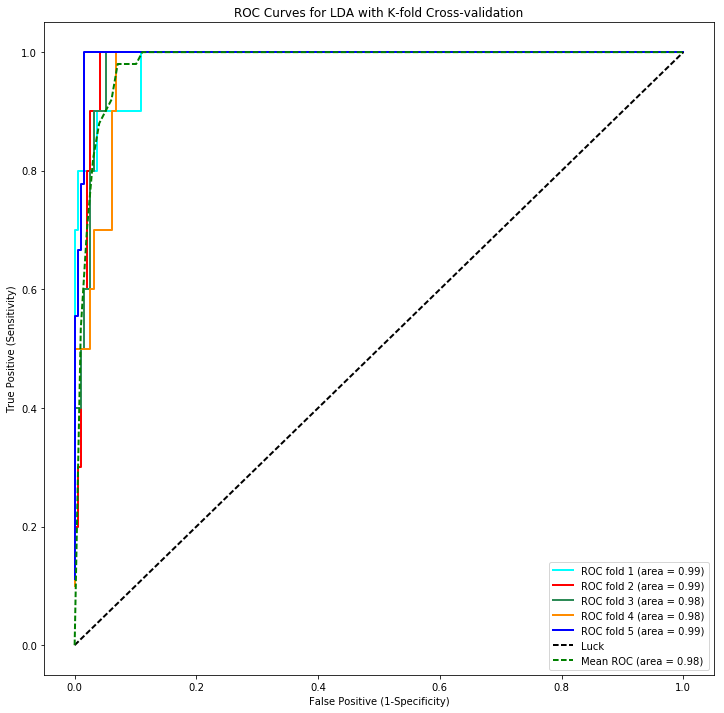

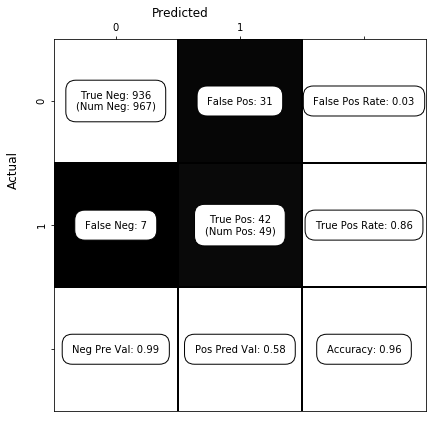

In [58]:
# Run LDA with cross-validation and plot ROC curves
rand = np.random.RandomState(0)
cv = StratifiedKFold(n_splits=num_cv, shuffle=True, random_state=rand)
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100) # `linspace` returns evenly spaced numbers over a specified interval.
roc_kfolds = []
cm_folds = []
lda_actual = []
lda_prob = []
best_mean_cutoff = 0.0
best_mean_tpr = 0.0
best_mean_fpr = 0.0
best_mean_ba = 0.0

# For each cross-validation batch, fit model 80:20 split, plot ROC, and get cutoff
# TODO - add feature selection per CV
# train, test are of type <type 'numpy.ndarray'>
i = 0
for (train, test) in cv.split(X, y):

    test_actual = y[test]
    test_X = X[test]
    train_X = X[train]
    train_y = y[train]
    
    # train LDA on training dataset
    lda = LinearDiscriminantAnalysis(solver=lda_solver,  
                                     shrinkage=lda_shrinkgage).fit(train_X, train_y)
       
    # test LDA on test dataset
    # predict probability returns <type 'numpy.ndarray'> (n_samples, n_classes)
    prob = lda.predict_proba(test_X)
    
    # get predicted values: 1/0; default threshold/cutoff is 0.5
    predicted = lda.predict(test_X)
    train_predicted = lda.predict(train_X)
    
    # Compute ROC curve
    # fpr = false positive rate (1-specificity)
    # tpr = true positive rate (sensitivity)
    fpr, tpr, thresholds = roc_curve(test_actual, prob[:, 1]) # returns <type 'numpy.ndarray'> x 3
    
    # add mean Sensitivity
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
  
    if output_data_to_excel:
        output_excel('lda-fold-%d-test' % (i+1), prob, test_X, test_actual, predicted, 'TestSet%d' % (i+1))
        output_excel('lda-fold-%d-train' % (i+1), 
                     lda.predict_proba(train_X), train_X, train_y, train_predicted, 'TrainSet%d' % (i+1))
    # /if...
    
    # get_cm_row(method, foldnum, cutoff, actual, prob)
    # append confusion matrix rows for output to Excel
    for cutoff in test_cutoffs:
        cm_folds.append( get_cm_row('LDA', i+1, cutoff, test_actual, prob) )
    
    
    lda_actual.extend(test_actual)
    lda_prob.extend(prob)
    
    roc_kfolds.append([tpr, fpr])
    
    #output_cutoffs(i, tpr, fpr, thresholds, prob)
    
    best_tpr, best_fpr, best_cutoff, best_ba = get_best_cutoff(actual=test_actual, prob=prob)
    print('Fold %d, TPR: %0.5f, FPR: %0.5f, Cutoff: %0.5f, BA: %0.5f' % (i+1, best_tpr, best_fpr, best_cutoff, best_ba))
    best_mean_cutoff += best_cutoff
    best_mean_tpr += best_tpr
    best_mean_fpr += best_fpr
    best_mean_ba += best_ba
    
    i += 1
#/for (train, test)...

best_mean_cutoff /= float(num_cv)
print('Means:  TPR: %0.5f, FPR: %0.5f, Cutoff: %0.5f, BA: %0.5f'%(best_mean_tpr/float(num_cv),
                                                    best_mean_fpr/float(num_cv), 
                                                    best_mean_cutoff, 
                                                    best_mean_ba/float(num_cv)))

show_roc(roc_kfolds, mean_tpr, mean_fpr, 'ROC Curves for LDA with K-fold Cross-validation', 2, 'lda-roc')

if output_data_to_excel:
    output_cms('lda-cms', cm_folds, 'LDA_Test_Folds') # output to excel
 

#Determine the best cutoff points and output confusion matrix
best_tp = get_confusion_matrix(best_mean_cutoff, logit_actual, logit_prob)
#best_accuracy =  get_confusion_matrix(0.5, logit_actual, logit_prob)
show_confusion_matrix(best_tp, ['0','1'], (6,6), 12, 'lda-best-tp-cm')
#show_confusion_matrix(best_accuracy, ['0','1'], (6,6), 12, 'lda-best-accuracy-cm')
 

Fold 1, TPR: 0.80000, FPR: 0.02577, Cutoff: 0.30000, BA: 0.88711
Fold 2, TPR: 0.90000, FPR: 0.06186, Cutoff: 0.16000, BA: 0.91907
Fold 3, TPR: 0.90000, FPR: 0.01036, Cutoff: 0.25000, BA: 0.94482
Fold 4, TPR: 0.80000, FPR: 0.02073, Cutoff: 0.21000, BA: 0.88964
Fold 5, TPR: 0.88889, FPR: 0.03109, Cutoff: 0.28000, BA: 0.92890
Means:  TPR: 0.85778, FPR: 0.02996, Cutoff: 0.24000, BA: 0.91391


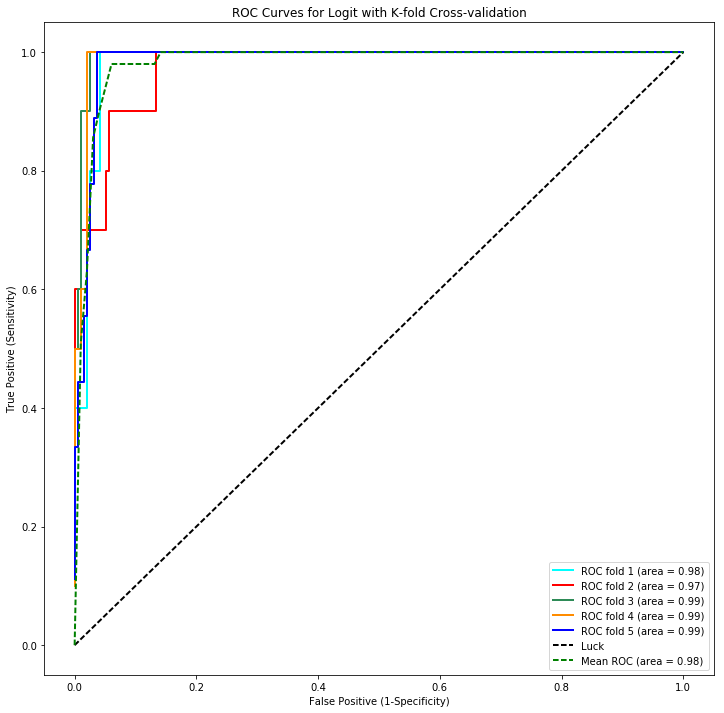

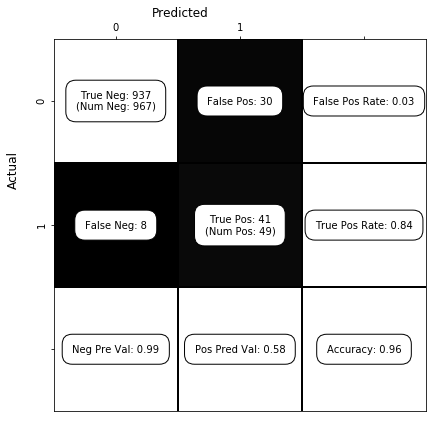

In [59]:
# Run logistic Regression with cross-validation and plot ROC curves

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100) # `linspace` returns evenly spaced numbers over a specified interval.
roc_kfolds = []
cm_folds = []
logit_actual = []
logit_prob = []
best_mean_cutoff = 0.0
best_mean_tpr = 0.0
best_mean_fpr = 0.0
best_mean_ba = 0.0

# For each cross-validation batch, fit model 80:20 split, plot ROC, and get cutoff
# TODO - add feature selection per CV
# train, test are of type <type 'numpy.ndarray'>
i = 0
for (train, test) in cv.split(X, y):

    test_actual = y[test]
    test_X = X[test]
    train_X = X[train]
    train_y = y[train]
    
    # train Logit on training dataset
    logit = LogisticRegression()
    logit.fit(train_X, train_y)
       
    # test Logit on test dataset
    # predict probability returns <type 'numpy.ndarray'> (n_samples, n_classes)
    prob = logit.predict_proba(test_X)
    
    # get predicted values: 1/0; default threshold/cutoff is 0.5
    predicted = logit.predict(test_X)
    train_predicted = logit.predict(train_X)
    
    # Compute ROC curve
    # fpr = false positive rate (1-specificity)
    # tpr = true positive rate (sensitivity)
    fpr, tpr, thresholds = roc_curve(test_actual, prob[:, 1]) # returns <type 'numpy.ndarray'> x 3
    
    # add mean Sensitivity
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
  
    if output_data_to_excel:
        output_excel('logit-fold-%d-test' % (i+1), prob, test_X, test_actual, predicted, 'TestSet%d' % (i+1))
        output_excel('logit-fold-%d-train' % (i+1), 
                     logit.predict_proba(train_X), train_X, train_y, train_predicted, 'TrainSet%d' % (i+1))
    # /if...
    
    # get_cm_row(method, foldnum, cutoff, actual, prob)
    # append confusion matrix rows for output to Excel
    for cutoff in test_cutoffs:
        cm_folds.append( get_cm_row('Logit', i+1, cutoff, test_actual, prob) )
    
    
    logit_actual.extend(test_actual)
    logit_prob.extend(prob)
    
    roc_kfolds.append([tpr, fpr])
    
    #output_cutoffs(i, tpr, fpr, thresholds, prob)
    
    best_tpr, best_fpr, best_cutoff, best_ba = get_best_cutoff(actual=test_actual, prob=prob)
    print('Fold %d, TPR: %0.5f, FPR: %0.5f, Cutoff: %0.5f, BA: %0.5f' % (i+1, best_tpr, best_fpr, best_cutoff, best_ba))
    best_mean_cutoff += best_cutoff
    best_mean_tpr += best_tpr
    best_mean_fpr += best_fpr
    best_mean_ba += best_ba
    
    i += 1
#/for (train, test)...

best_mean_cutoff /= float(num_cv)

print('Means:  TPR: %0.5f, FPR: %0.5f, Cutoff: %0.5f, BA: %0.5f'%(best_mean_tpr/float(num_cv),
                                                    best_mean_fpr/float(num_cv), 
                                                    best_mean_cutoff, 
                                                    best_mean_ba/float(num_cv)))

show_roc(roc_kfolds, mean_tpr, mean_fpr, 'ROC Curves for Logit with K-fold Cross-validation', 2, 'logit-roc')

if output_data_to_excel:
    output_cms('logit-cms', cm_folds, 'Logit_Test_Folds') # output to excel
  
#Determine the best cutoff points and output confusion matrix
best_tp = get_confusion_matrix(best_mean_cutoff, logit_actual, logit_prob)
#best_accuracy =  get_confusion_matrix(0.5, logit_actual, logit_prob)
show_confusion_matrix(best_tp, ['0','1'], (6,6), 12, 'logit-best-tp-cm')
#show_confusion_matrix(best_accuracy, ['0','1'], (6,6), 12, 'logit-best-accuracy-cm')
 